<a href="https://colab.research.google.com/github/OmarMoghazy/CNN-Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import IPython
from IPython.core.display import display
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from sklearn import preprocessing
import math
import gc
import pandas as pd

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, concatenate
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPool1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2

# Speech Emotion Recognition

Speech is the most natural way of expressing ourselves as humans. It is only natural
then to extend this communication medium to computer applications. We define
speech emotion recognition (SER) systems as a collection of methodologies that
process and classify speech signals to detect the embedded emotions.

## The Dataset (CREMA-D)




https://github.com/CheyneyComputerScience/CREMA-D

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified).

Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral and Sad) and four different emotion levels (Low, Medium, High and Unspecified).

Participants rated the emotion and emotion levels based on the combined audiovisual presentation, the video alone, and the audio alone. Due to the large number of ratings needed, this effort was crowd-sourced and a total of 2443 participants each rated 90 unique clips, 30 audio, 30 visual, and 30 audio-visual. 95% of the clips have more than 7 ratings.

### Filename Labeling Conventions

The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).


Actors spoke from a selection of 12 sentences (in parentheses is the three letter acronym used in the second part of the filename):

It's eleven o'clock (IEO).

That is exactly what happened (TIE).

I'm on my way to the meeting (IOM).

I wonder what this is about (IWW).

The airplane is almost full (TAI).

Maybe tomorrow it will be cold (MTI).

I would like a new alarm clock (IWL)

I think I have a doctor's appointment (ITH).

Don't forget a jacket (DFA).

I think I've seen this before (ITS).

The surface is slick (TSI).

We'll stop in a couple of minutes (WSI).

The sentences were presented using different emotion (in parentheses is the three letter code used in the third part of the filename):

Anger (ANG)

Disgust (DIS)

Fear (FEA)

Happy/Joy (HAP)

Neutral (NEU)

Sad (SAD)

and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

Low (LO)

Medium (MD)

High (HI)

Unspecified (XX)

The suffix of the filename is based on the type of file, flv for flash video used for presentation of both the video only, and the audio-visual clips. mp3 is used for the audio files used for the audio-only presentation of the clips. wav is used for files used for computational audio processing.

For our task, we are only going to use the .wav files.

## Data Preparation

The first step is reading the data and splitting it into training, testing and validation.

In [ ]:
dataset_path = './drive/MyDrive/Speech Emotion Recognition/Dataset/Crema'
files = os.listdir(dataset_path)

We will split the dataset into training data and testing data by actor. There are 91 actors. Actor IDs start from 1001 up to 1091. 

In [ ]:
IDs = np.arange(1001,1092)
training_IDs, testing_IDs = train_test_split(IDs, test_size=0.3, random_state=42)

In [ ]:
training_IDs = set(training_IDs)
testing_IDs = set(testing_IDs)

for filename in files:
  if int(filename[0:4]) in training_IDs:
    shutil.copyfile(dataset_path + '/' + filename, dataset_path + "/.." + "/training/" + filename)
  else:
    shutil.copyfile(dataset_path + '/' + filename, dataset_path + "/.." + "/testing/" + filename)


Next, we will split the training data into training and validation.

In [ ]:
training_IDs_2, validation_IDs = train_test_split(list(training_IDs), test_size=0.05, random_state=42)

In [ ]:
validation_IDs = set(validation_IDs)

In [ ]:
for filename in files:
  if int(filename[0:4]) in validation_IDs:
    shutil.move(dataset_path + "/.." + "/training/" + filename, dataset_path + "/.." + "/validation/" + filename)

We need the filename of each of the audio files, which will be used:
 
*   to read the wav file
*   to get the actor id, emotion and emotion level.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_data_path = './drive/MyDrive/Speech Emotion Recognition/Dataset/training'
training_files = os.listdir(training_data_path)

In [ ]:
testing_data_path = './drive/MyDrive/Speech Emotion Recognition/Dataset/testing'
testing_files = os.listdir(testing_data_path)

In [ ]:
validation_data_path = './drive/MyDrive/Speech Emotion Recognition/Dataset/validation'
validation_files = os.listdir(validation_data_path)

The following function takes a single parameter which is the path to an audio file. It displays a player for the audio file, plots its waveform and displays its Mel spectogram. It also displays some information about the file such as duration in seconds, sampling rate and number of samples.

In [ ]:
def el3abat(path):
  '''Displays player for the audio file.
  Plots the waveform of the audio file.
  Plots the Mel spectogram of the audio file'''

  display(IPython.display.Audio(path))

  data, fs = librosa.load(path, sr=None)

  duration = data.size/fs

  print("Duration:\t" + str(duration) + " seconds")
  print("Sampling rate:\t" + str(fs) + " samples per second")
  print("Signal size:\t" + str(data.size) + " samples")
  print()

  librosa.display.waveplot(data, sr=fs)
  plt.title("Time Domain Waveform")
  plt.show()
  print()
  sgram = librosa.stft(data)
  # librosa.display.specshow(sgram)
  print('Mel spectogram')
  sgram_mag, _ = librosa.magphase(sgram)
  mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=fs)
  librosa.display.specshow(mel_scale_sgram)
  plt.show()

Duration:	2.93625 seconds
Sampling rate:	16000 samples per second
Signal size:	46980 samples



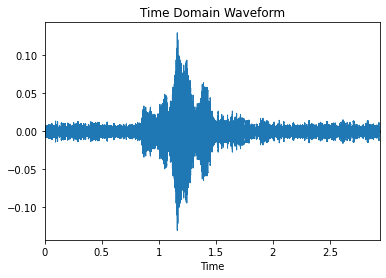


Mel Spectogram


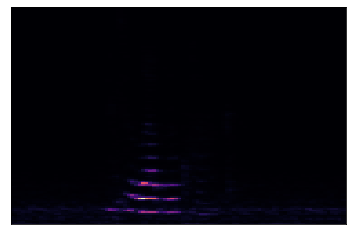

In [ ]:
path = training_data_path + '/' + training_files[8]
el3abat(path)

We need to make sure that all the audio files have the same duration. We will add padding (of silence) to all audio files that have less samples than the maximum. But first, we need to find the maximum.

In [ ]:
# max = 0
# for f in files:
#   path = path = dataset_path + '/' + f
#   # data, fs = librosa.load(path, sr=None)
#   s = librosa.get_duration(filename=path)
#   if s > max:
#     max = s
#     print(max, fs, filename) 

3.536875 16000 1037_IEO_ANG_HI.wav
3.603625 16000 1037_IEO_ANG_HI.wav
3.6703125 16000 1037_IEO_ANG_HI.wav
3.970625 16000 1037_IEO_ANG_HI.wav
4.2041875 16000 1037_IEO_ANG_HI.wav
4.3376875 16000 1037_IEO_ANG_HI.wav
4.404375 16000 1037_IEO_ANG_HI.wav
4.537875 16000 1037_IEO_ANG_HI.wav
4.7714375 16000 1037_IEO_ANG_HI.wav
4.8048125 16000 1037_IEO_ANG_HI.wav
4.8715625 16000 1037_IEO_ANG_HI.wav
4.971625 16000 1037_IEO_ANG_HI.wav
5.005 16000 1037_IEO_ANG_HI.wav


From the outout of the previous cell, we can see that the Longest duration is 5.005 seconds. Therefore, the maximum number of samples in the dataset is 80080 samples.

For every audio file in the dataset, if it has less than 80100 samples, we will add zero-padding to get it to 80100 samples. Then, we are going to normalize it then generate its Mel spectogram and save it to google drive.

### First Feature Space

#### Waveform

In [ ]:
Z = []
count = 0
for filename in training_files:
  count = count + 1
  #load file
  path = training_data_path + '/' + filename
  data, fs = librosa.load(path, sr=None)
  
  add padding
  if data.size < 80100:
    padding = 80100 - data.size
    if padding%2 == 0:
      data = np.hstack((data, np.zeros(padding//2)))
      data = np.hstack((np.zeros(padding//2), data))
    else:
      data = np.hstack((data, np.zeros(padding//2)))
      data = np.hstack((np.zeros(padding//2 + 1), data))
  Z.append(data)
  librosa.display.waveplot(data, sr=fs)
  np.save("drive/MyDrive/Speech Emotion Recognition/Training padded waveforms/"+ filename[:-4] + ".npy", data)
  if count % 100 == 0:
    print(count, end=' ')

  # produce Mel spectogram
  # sgram = librosa.stft(data)
  # sgram_mag, _ = librosa.magphase(sgram)
  # mel_scale_sgram = librosa.feature.melspectogram(S=sgram_mag, sr=fs)
  # librosa.display.specshow(mel_scale_sgram)

  # save to google drive
  # np.save("drive/MyDrive/Speech Emotion Recognition/Training Mel spectograms/"+ filename[:-4] + ".npy", mel_scale_sgram)

In [ ]:
Z = []
for filename in training_files:
  Z.append(np.load("drive/MyDrive/Speech Emotion Recognition/Training padded waveforms/"+ filename[:-4] + ".npy"))

Z = np.array(Z)

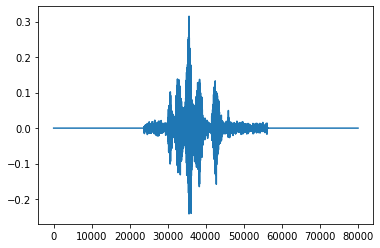

In [ ]:
plt.plot(Z[0])

In [ ]:
mean = np.mean(Z, axis=0)
std = np.std(Z, axis=0)

np.save('drive/MyDrive/Speech Emotion Recognition/training_mean.npy', mean)
np.save('drive/MyDrive/Speech Emotion Recognition/training_std.npy', std)

In [ ]:
mean = np.load('drive/MyDrive/Speech Emotion Recognition/training_mean.npy')
std = np.load('drive/MyDrive/Speech Emotion Recognition/training_std.npy')

Mean of the dataset: [0. 0. 0. ... 0. 0. 0.]
Standard deviation for the dataset: [0. 0. 0. ... 0. 0. 0.]


Text(0.5, 1.0, 'Standard Deviation')

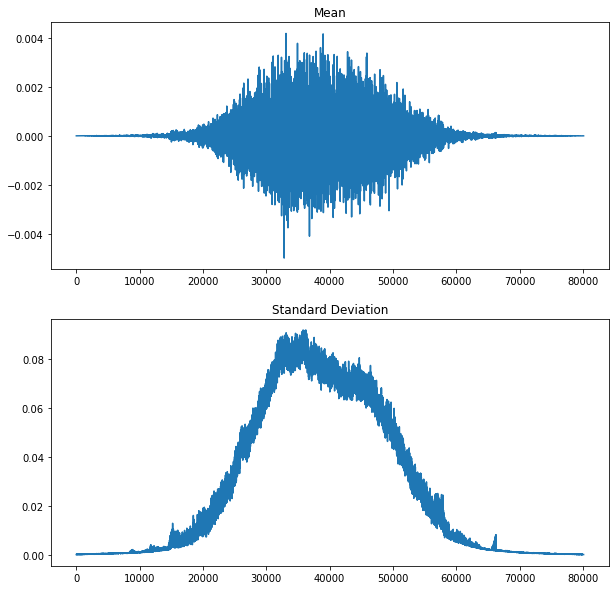

In [ ]:
print('Mean of the dataset: ' + str(mean))
print('Standard deviation for the dataset: ' + str(std))

fig, axes = plt.subplots(2,1)
fig.set_size_inches(10,10)
axes[0].plot(mean)
axes[0].set_title('Mean')

axes[1].plot(std)
axes[1].set_title('Standard Deviation')

There are some zeros in the standard deviation, which will affect our normalization process because we divide by the standard deviation.

We will set all 0 values of standard deviation to 1 instead, which makes sense because 0 standard deviation means all values for this feature are equal to the mean, so the normalized (centered and scales) value for this feature will be 0, which means it does not deviate from the mean.

In [ ]:
zeros = np.where(std == 0)
std[zeros] = 1

Normalizing the data after calculating the mean and variance.

In [ ]:
for filename in training_files:
  temp = np.load('drive/MyDrive/Speech Emotion Recognition/Training padded waveforms/' + filename[:-4] + '.npy')
  temp = (temp-mean)/std
  np.save('drive/MyDrive/Speech Emotion Recognition/Training normalized waveforms/' + filename[:-4] + '.npy', temp)

#### Zero Crossing Rate and Energy
ZCR: The rate of sign-changes of the signal during
the duration of a particular frame.

Energy: The sum of squares of the signal values, normalized by
the respective frame length.

In [ ]:
zcrs = []
energy = []
count = 0
for filename in training_files:
  count = count + 1
  if count % 100 == 0:
    print(count, end=' ')
  data, fs = librosa.load('drive/MyDrive/Speech Emotion Recognition/Dataset/training/' + filename[:-4] + '.wav', sr=None)
  zcrs.append(np.sum(librosa.feature.zero_crossing_rate(data, pad=False)))
  energy.append(np.sum(np.square(data))/data.size)

In [ ]:
np.save('drive/MyDrive/Speech Emotion Recognition/ZCR.npy', zcrs)
np.save('drive/MyDrive/Speech Emotion Recognition/energy.npy', energy)

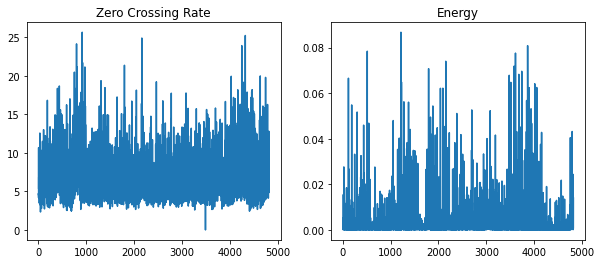

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10,4)

axes[0].set_title('Zero Crossing Rate')
axes[0].plot(zcrs)
axes[1].set_title('Energy')
axes[1].plot(energy)

### Second Feature Space

#### Mel spectograms

Next, we are going to read the entire dataset and produce a Mel spectogram for each audio file which we will save to google drive as a numpy array using the same naming conventions.

We will use these Mel spectograms as the second feature space.

[Read more about Mel spectograms and why they are using for deep learning here](https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectograms-perform-better-aad889a93505).

In [ ]:
fs = 16000
S = []
count = 0

for filename in training_files:
  count = count + 1
  if count % 100 ==0:
    print(count)
  temp = np.load('drive/MyDrive/Speech Emotion Recognition/Training normalized waveforms/' + filename[:-4] + '.npy')

  # produce Mel spectogram
  sgram = librosa.stft(temp)
  sgram_mag, _ = librosa.magphase(sgram)
  mel_scale_sgram = librosa.feature.melspectogram(S=sgram_mag, sr=fs)
  
  S.append(mel_scale_sgram)
  # librosa.display.specshow(mel_scale_sgram)

  # save to google drive
  # np.save("drive/MyDrive/Speech Emotion Recognition/Training Mel spectograms/"+ filename[:-4] + ".npy", mel_scale_sgram)

Next, we will calculate the normalization statistics for the mel spectograms

In [ ]:
mean = np.mean(S, axis=0)
std = np.std(S, axis=0)

np.save('drive/MyDrive/Speech Emotion Recognition/training_spectogram_mean.npy', mean)
np.save('drive/MyDrive/Speech Emotion Recognition/training_spectogram_std.npy', std)

In [ ]:
zeros = np.where(std==0)
std[zeros] = 1

Now we will normalize the spectograms using the normalization statistics that we just calculated.

In [ ]:
fs = 16000
count = 0
for filename in training_files:
  count = count + 1
  if count % 100 == 0:
    print(count, end=' ')
  temp = np.load('drive/MyDrive/Speech Emotion Recognition/Training normalized waveforms/' + filename[:-4] + '.npy')

   # produce Mel spectogram
  sgram = librosa.stft(temp)
  sgram_mag, _ = librosa.magphase(sgram)
  mel_scale_sgram = librosa.feature.melspectogram(S=sgram_mag, sr=fs)

  # normalization
  temp = (mel_scale_sgram - mean) / std

  # save to google drive
  np.save('drive/MyDrive/Speech Emotion Recognition/Training normalized Mel Spectograms/' + filename[:-4] + '.npy', temp)

## Feature Extraction

### Training

In [ ]:
df = pd.DataFrame(columns=['power_max', 'power_mean', 'power_min', 'power_median', 'power_range', 'power_std', 'power_var',
                           'zcr_max', 'zcr_mean', 'zcr_min', 'zcr_median', 'zcr_range', 'zcr_std', 'zcr_var', 'spectogram', 'filename',
                           'label'])
count = 0
spectograms = []
labels = []
for i, filename in zip(range(len(training_files)),training_files):
  count = count + 1
  if count % 100 == 0:
    print(count, end=' ')
  powers = []
  power_max = float('-inf')
  power_mean = 0
  power_min = float('inf')
  power_median = 0
  power_range = 0
  power_std = 0
  power_var = 0

  zcrs = []
  zcr_max = float('-inf')
  zcr_mean = 0
  zcr_min = float('inf')
  zcr_median = 0
  zcr_range = 0
  zcr_std = 0
  zcr_var = 0

  data, fs = librosa.load('drive/MyDrive/Speech Emotion Recognition/Dataset/training/' + filename[:-4] + '.wav', sr=None)
  chunk_size = 256
  chuggs = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
  for chunk in chuggs:
    chunk_power = np.mean(np.sum(chunk**2))
    powers.append(chunk_power)
    if power_max < chunk_power:
      power_max = chunk_power
    if power_min > chunk_power:
      power_min = chunk_power
    
    chunk_zcr = np.sum(librosa.feature.zero_crossing_rate(chunk, pad=False))
    zcrs.append(chunk_zcr)
    if zcr_max < chunk_zcr:
      zcr_max = chunk_zcr
    if zcr_min > chunk_zcr:
      zcr_min = chunk_zcr

  power_mean = np.mean(powers)
  power_median = np.median(powers)
  power_range = power_max - power_median
  power_std = np.std(powers)
  power_var = np.var(powers)

  zcr_mean = np.mean(zcrs)
  zcr_median = np.median(zcrs)
  zcr_range = zcr_max - zcr_min
  zcr_std = np.std(zcrs)
  zcr_var = np.var(zcrs)


  s = np.load('/content/drive/MyDrive/Speech Emotion Recognition/Training normalized Mel Spectograms/'+filename[:-4]+'.npy')

  spectograms.append(s)

  
  label = filename.split('_')[2]

  labels.append(label)

  if label == 'ANG':
    label = 0
  elif label == 'DIS':
    label = 1
  elif label == 'FEA':
    label = 2
  elif label == 'HAP':
    label = 3
  elif label == 'NEU':
    label = 4
  elif label == 'SAD':
    label = 5


  df.loc[i] = {'power_max':power_max,'power_mean':power_mean,'power_min':power_min,
               'power_median':power_median,'power_range':power_range,'power_std':power_std,
               'power_var':power_var, 'zcr_max':zcr_max, 'zcr_mean':zcr_mean,'zcr_min':zcr_min,
               'zcr_median':zcr_median, 'zcr_range':zcr_range, 'zcr_std':zcr_std,
               'zcr_var':zcr_var, 'spectogram':s, 'filename':filename,'label':label}

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 

In [ ]:
_1d_mean = np.mean(df.drop(columns = ['spectogram', 'filename', 'label']), axis=0)
_1d_std = np.std(df.drop(columns = ['spectogram', 'filename', 'label']), axis=0)

np.save('drive/MyDrive/Speech Emotion Recognition/1d_mean.npy', _1d_mean)
np.save('drive/MyDrive/Speech Emotion Recognition/1d_std.npy', _1d_std)

df = pd.concat(((df.drop(columns = ['spectogram', 'filename', 'label']) - _1d_mean) / _1d_std, df[['spectogram', 'filename', 'label']]), axis=1)

### Validation

In [ ]:
df_v = pd.DataFrame(columns=['power_max', 'power_mean', 'power_min', 'power_median', 'power_range', 'power_std', 'power_var',
                           'zcr_max', 'zcr_mean', 'zcr_min', 'zcr_median', 'zcr_range', 'zcr_std', 'zcr_var', 'spectogram', 'filename',
                           'label'])
count = 0
spectograms = []
labels = []

mean_aaa = np.load('/content/drive/MyDrive/Speech Emotion Recognition/1d_mean.npy')
std_aaa = np.load('/content/drive/MyDrive/Speech Emotion Recognition/1d_std.npy')

_1d_mean = np.load('/content/drive/MyDrive/Speech Emotion Recognition/training_mean.npy')
_1d_std = np.load('/content/drive/MyDrive/Speech Emotion Recognition/training_std.npy')

_2d_mean = np.load('drive/MyDrive/Speech Emotion Recognition/training_spectogram_mean.npy')
_2d_std = np.load('drive/MyDrive/Speech Emotion Recognition/training_spectogram_std.npy')

for i, filename in zip(range(len(validation_files)),validation_files):
  count = count + 1
  if count % 100 == 0:
    print(count, end=' ')
  powers = []
  power_max = float('-inf')
  power_mean = 0
  power_min = float('inf')
  power_median = 0
  power_range = 0
  power_std = 0
  power_var = 0

  zcrs = []
  zcr_max = float('-inf')
  zcr_mean = 0
  zcr_min = float('inf')
  zcr_median = 0
  zcr_range = 0
  zcr_std = 0
  zcr_var = 0

  data, fs = librosa.load('/content/drive/MyDrive/Speech Emotion Recognition/Dataset/validation/'+filename, sr=None)

  chunk_size = 256
  chuggs = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
  for chunk in chuggs:
    chunk_power = np.mean(np.sum(chunk**2))
    powers.append(chunk_power)
    if power_max < chunk_power:
      power_max = chunk_power
    if power_min > chunk_power:
      power_min = chunk_power
    
    chunk_zcr = np.sum(librosa.feature.zero_crossing_rate(chunk, pad=False))
    zcrs.append(chunk_zcr)
    if zcr_max < chunk_zcr:
      zcr_max = chunk_zcr
    if zcr_min > chunk_zcr:
      zcr_min = chunk_zcr

  power_mean = np.mean(powers)
  power_median = np.median(powers)
  power_range = power_max - power_median
  power_std = np.std(powers)
  power_var = np.var(powers)

  zcr_mean = np.mean(zcrs)
  zcr_median = np.median(zcrs)
  zcr_range = zcr_max - zcr_min
  zcr_std = np.std(zcrs)
  zcr_var = np.var(zcrs)

  if data.size < 80100:
    padding = 80100 - data.size
    if padding%2 == 0:
      data = np.hstack((data, np.zeros(padding//2)))
      data = np.hstack((np.zeros(padding//2), data))
    else:
      data = np.hstack((data, np.zeros(padding//2)))
      data = np.hstack((np.zeros(padding//2 + 1), data))

  zeros = np.where(_1d_std == 0)
  _1d_std[zeros] = 1
  
  data = (data-_1d_mean)/_1d_std

  sgram = librosa.stft(data)
  sgram_mag, _ = librosa.magphase(sgram)
  s = librosa.feature.melspectrogram(S=sgram_mag, sr=fs)

  s = (s - _2d_mean) / _2d_std 
  s = s.reshape(-1,157,128,1)
  spectograms.append(s)
  
  label = filename.split('_')[2]

  labels.append(label)

  if label == 'ANG':
    label = 0
  elif label == 'DIS':
    label = 1
  elif label == 'FEA':
    label = 2
  elif label == 'HAP':
    label = 3
  elif label == 'NEU':
    label = 4
  elif label == 'SAD':
    label = 5


  df_v.loc[i] = {'power_max':power_max,'power_mean':power_mean,'power_min':power_min,
               'power_median':power_median,'power_range':power_range,'power_std':power_std,
               'power_var':power_var, 'zcr_max':zcr_max, 'zcr_mean':zcr_mean,'zcr_min':zcr_min,
               'zcr_median':zcr_median, 'zcr_range':zcr_range, 'zcr_std':zcr_std,
               'zcr_var':zcr_var, 'spectogram':s, 'filename':filename,'label':label}

df_v = pd.concat(((df_v.drop(columns = ['spectogram', 'filename', 'label']) - mean_aaa) / std_aaa, df_v[['spectogram', 'filename', 'label']]), axis=1)

100 200 300 

### Testing

In [ ]:
df_t = pd.DataFrame(columns=['power_max', 'power_mean', 'power_min', 'power_median', 'power_range', 'power_std', 'power_var',
                           'zcr_max', 'zcr_mean', 'zcr_min', 'zcr_median', 'zcr_range', 'zcr_std', 'zcr_var', 'spectogram', 'filename',
                           'label'])
count = 0
spectograms = []
labels = []

mean_aaa = np.load('/content/drive/MyDrive/Speech Emotion Recognition/1d_mean.npy')
std_aaa = np.load('/content/drive/MyDrive/Speech Emotion Recognition/1d_std.npy')

_1d_mean = np.load('/content/drive/MyDrive/Speech Emotion Recognition/training_mean.npy')
_1d_std = np.load('/content/drive/MyDrive/Speech Emotion Recognition/training_std.npy')

_2d_mean = np.load('drive/MyDrive/Speech Emotion Recognition/training_spectogram_mean.npy')
_2d_std = np.load('drive/MyDrive/Speech Emotion Recognition/training_spectogram_std.npy')

for i, filename in zip(range(len(testing_files)),testing_files):
  count = count + 1
  if count % 100 == 0:
    print(count, end=' ')
  powers = []
  power_max = float('-inf')
  power_mean = 0
  power_min = float('inf')
  power_median = 0
  power_range = 0
  power_std = 0
  power_var = 0

  zcrs = []
  zcr_max = float('-inf')
  zcr_mean = 0
  zcr_min = float('inf')
  zcr_median = 0
  zcr_range = 0
  zcr_std = 0
  zcr_var = 0

  data, fs = librosa.load('/content/drive/MyDrive/Speech Emotion Recognition/Dataset/testing/'+filename, sr=None)

  chunk_size = 256
  chuggs = [data[x:x+chunk_size] for x in range(0, len(data), chunk_size)]
  for chunk in chuggs:
    chunk_power = np.mean(np.sum(chunk**2))
    powers.append(chunk_power)
    if power_max < chunk_power:
      power_max = chunk_power
    if power_min > chunk_power:
      power_min = chunk_power
    
    chunk_zcr = np.sum(librosa.feature.zero_crossing_rate(chunk, pad=False))
    zcrs.append(chunk_zcr)
    if zcr_max < chunk_zcr:
      zcr_max = chunk_zcr
    if zcr_min > chunk_zcr:
      zcr_min = chunk_zcr

  power_mean = np.mean(powers)
  power_median = np.median(powers)
  power_range = power_max - power_median
  power_std = np.std(powers)
  power_var = np.var(powers)

  zcr_mean = np.mean(zcrs)
  zcr_median = np.median(zcrs)
  zcr_range = zcr_max - zcr_min
  zcr_std = np.std(zcrs)
  zcr_var = np.var(zcrs)

  if data.size < 80100:
    padding = 80100 - data.size
    if padding%2 == 0:
      data = np.hstack((data, np.zeros(padding//2)))
      data = np.hstack((np.zeros(padding//2), data))
    else:
      data = np.hstack((data, np.zeros(padding//2)))
      data = np.hstack((np.zeros(padding//2 + 1), data))

  zeros = np.where(_1d_std == 0)
  _1d_std[zeros] = 1
  
  data = (data-_1d_mean)/_1d_std

  sgram = librosa.stft(data)
  sgram_mag, _ = librosa.magphase(sgram)
  s = librosa.feature.melspectrogram(S=sgram_mag, sr=fs)

  s = (s - _2d_mean) / _2d_std 
  s = s.reshape(-1,157,128,1)
  spectograms.append(s)
  
  label = filename.split('_')[2]

  labels.append(label)

  if label == 'ANG':
    label = 0
  elif label == 'DIS':
    label = 1
  elif label == 'FEA':
    label = 2
  elif label == 'HAP':
    label = 3
  elif label == 'NEU':
    label = 4
  elif label == 'SAD':
    label = 5


  df_t.loc[i] = {'power_max':power_max,'power_mean':power_mean,'power_min':power_min,
               'power_median':power_median,'power_range':power_range,'power_std':power_std,
               'power_var':power_var, 'zcr_max':zcr_max, 'zcr_mean':zcr_mean,'zcr_min':zcr_min,
               'zcr_median':zcr_median, 'zcr_range':zcr_range, 'zcr_std':zcr_std,
               'zcr_var':zcr_var, 'spectogram':s, 'filename':filename,'label':label}

df_t = pd.concat(((df_t.drop(columns = ['spectogram', 'filename', 'label']) - mean_aaa) / std_aaa, df_t[['spectogram', 'filename', 'label']]), axis=1)

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 

In [ ]:
x1_training = np.asarray(df.drop(columns=['filename', 'label', 'spectogram','zcr_median','power_median','zcr_var','power_var'])).astype('float32').reshape(-1,10,1)
x2_training = np.array([x for x in df['spectogram']]).reshape(-1,157,128,1)
y_training = np.array(df['label']).astype('int32').reshape((-1,1))

x1_validation = np.asarray(df_v.drop(columns=['filename', 'label', 'spectogram','zcr_median','power_median','zcr_var','power_var'])).astype('float32').reshape(-1,10,1)
x2_validation = np.array([x for x in df_v['spectogram']]).reshape(-1,157,128,1)
y_validation = np.array(df_v['label']).astype('int32').reshape((-1,1))

x1_testing = np.asarray(df_t.drop(columns=['filename', 'label', 'spectogram','zcr_median','power_median','zcr_var','power_var'])).astype('float32').reshape(-1,10,1)
x2_testing = np.array([x for x in df_t['spectogram']]).reshape(-1,157,128,1)
y_testing = np.array(df_t['label']).astype('int32').reshape((-1,1))

## CNN

In [ ]:
batch_size = 64
epochs = 20
num_classes = 6

### 1D Convolution

In [ ]:
i = Input(shape=(10,1))
x = Dropout(0.2)(i)
x = Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=l2(), bias_regularizer=l2())(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)
x = Conv1D(filters=256, kernel_size=3, activation='linear', kernel_regularizer=l2(), bias_regularizer=l2())(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='linear', kernel_regularizer=l2(), bias_regularizer=l2())(x)
x1 = LeakyReLU(alpha=0.1)(x)
x = Dense(6, activation='softmax')(x1)

x = Model(inputs=[i],outputs=[x])
x2 = Model(inputs=[i],outputs=[x1])

In [ ]:
x.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
x.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 8, 128)            512       
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 8, 128)            0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 8, 128)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 6, 256)            98560     
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 6, 256)            0  

In [ ]:
x_history = x.fit(x1_training, y_training, batch_size=batch_size,epochs=200,verbose=1,validation_data=(x1_validation, y_validation))

Epoch 1/200
76/76 [==============================] - 2s 9ms/step - loss: 1.6128 - accuracy: 0.3425 - val_loss: 1.6247 - val_accuracy: 0.3506
Epoch 2/200
76/76 [==============================] - 0s 4ms/step - loss: 1.5949 - accuracy: 0.3569 - val_loss: 1.6561 - val_accuracy: 0.3354
Epoch 3/200
76/76 [==============================] - 0s 4ms/step - loss: 1.6036 - accuracy: 0.3515 - val_loss: 1.6423 - val_accuracy: 0.3323
Epoch 4/200
76/76 [==============================] - 0s 4ms/step - loss: 1.5854 - accuracy: 0.3569 - val_loss: 1.6437 - val_accuracy: 0.3537
Epoch 5/200
76/76 [==============================] - 0s 4ms/step - loss: 1.6059 - accuracy: 0.3533 - val_loss: 1.6378 - val_accuracy: 0.3445
Epoch 6/200
76/76 [==============================] - 0s 4ms/step - loss: 1.6023 - accuracy: 0.3466 - val_loss: 1.6357 - val_accuracy: 0.3476
Epoch 7/200
76/76 [==============================] - 0s 4ms/step - loss: 1.6069 - accuracy: 0.3634 - val_loss: 1.6435 - val_accuracy: 0.3079
Epoch 8/200
7

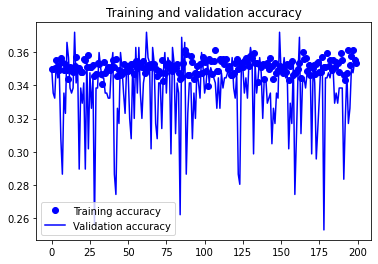

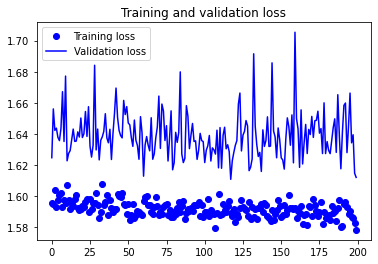

In [ ]:
accuracy = x_history.history['accuracy']
val_accuracy = x_history.history['val_accuracy']
loss = x_history.history['loss']
val_loss = x_history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 2D Convolution 

In [ ]:
i1 = Input(shape=(157,128,1))
c1 = Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same')(i1)
a1 = LeakyReLU(alpha=0.1)(c1)
p1 = MaxPooling2D((2, 2),padding='same')(a1)

d1 = Dropout(0.5)(p1)
c2 = Conv2D(64, (3, 3), activation='linear',padding='same')(d1)
a2 = LeakyReLU(alpha=0.1)(c2)
p2 = MaxPooling2D(pool_size=(2, 2),padding='same')(a2)

d2 = Dropout(0.5)(p2)
c3 = Conv2D(128, (3, 3), activation='linear',padding='same')(d2)
a3 = LeakyReLU(alpha=0.1)(c3)
p3 = MaxPooling2D(pool_size=(2, 2),padding='same')(a3)

d3 = Dropout(0.7)(p2)
c4 = Conv2D(256, (3, 3), activation='linear',padding='same')(d3)
a4 = LeakyReLU(alpha=0.1)(c3)
p4 = MaxPooling2D(pool_size=(2, 2),padding='same')(a4)

f1 = Flatten()(p4)

d5 = Dropout(0.7)(f1)
a5 = LeakyReLU(alpha=0.1)(d5)
fc1 = Dense(256, activation='linear')(a5)
fc2 = Dense(num_classes, activation='softmax')(fc1)

fashion_model = Model(inputs=[i1],outputs=[fc2])


y = Model(inputs=[i1],outputs=[fc2])
y2 = Model(inputs=[i1], outputs=[a5])

In [ ]:
y.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
y.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 157, 128, 1)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 157, 128, 32)      320       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 157, 128, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 79, 64, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 79, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 79, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 79, 64, 64)        0  

In [ ]:
y_history = y.fit(x2_training, y_training, batch_size=batch_size,epochs=50,verbose=1,validation_data=(x2_validation, y_validation))

Epoch 1/50
76/76 [==============================] - 5s 54ms/step - loss: 6.4586 - accuracy: 0.1984 - val_loss: 1.9299 - val_accuracy: 0.2012
Epoch 2/50
76/76 [==============================] - 4s 49ms/step - loss: 1.6719 - accuracy: 0.3011 - val_loss: 2.1510 - val_accuracy: 0.2348
Epoch 3/50
76/76 [==============================] - 4s 49ms/step - loss: 1.6124 - accuracy: 0.3498 - val_loss: 2.1613 - val_accuracy: 0.2165
Epoch 4/50
76/76 [==============================] - 4s 49ms/step - loss: 1.5806 - accuracy: 0.3603 - val_loss: 2.6933 - val_accuracy: 0.2530
Epoch 5/50
76/76 [==============================] - 4s 49ms/step - loss: 1.4970 - accuracy: 0.3897 - val_loss: 1.8611 - val_accuracy: 0.3354
Epoch 6/50
76/76 [==============================] - 4s 49ms/step - loss: 1.4835 - accuracy: 0.3837 - val_loss: 1.7476 - val_accuracy: 0.3994
Epoch 7/50
76/76 [==============================] - 4s 49ms/step - loss: 1.4531 - accuracy: 0.4208 - val_loss: 2.1387 - val_accuracy: 0.3537
Epoch 8/50
76

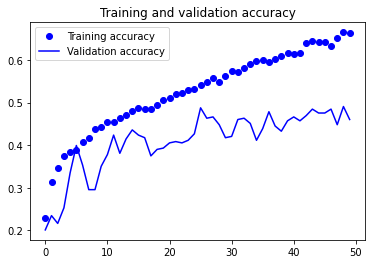

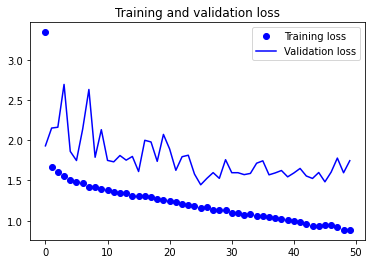

In [ ]:
accuracy = y_history.history['accuracy']
val_accuracy = y_history.history['val_accuracy']
loss = y_history.history['loss']
val_loss = y_history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Combined Model

In [ ]:
combined = concatenate([x2.output, y2.output])

z = Dense(128, kernel_regularizer=l2(), bias_regularizer=l2())(combined)
z = LeakyReLU(alpha=0.1)(z)
z = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[x2.input, y2.input], outputs=z)

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 157, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 157, 128, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, 157, 128, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 14, 1)]      0                                            
___________________________________________________________________________________________

In [ ]:
model_history = model.fit(x=[x1_training,x2_training], y=y_training, batch_size=batch_size,epochs=30,verbose=1,validation_data=([x1_validation, x2_validation], y_validation))

Epoch 1/30
76/76 [==============================] - 6s 59ms/step - loss: 3.0202 - accuracy: 0.4125 - val_loss: 2.1888 - val_accuracy: 0.4695
Epoch 2/30
76/76 [==============================] - 4s 50ms/step - loss: 1.9925 - accuracy: 0.5328 - val_loss: 2.1572 - val_accuracy: 0.4848
Epoch 3/30
76/76 [==============================] - 4s 50ms/step - loss: 2.0378 - accuracy: 0.5651 - val_loss: 2.3376 - val_accuracy: 0.4726
Epoch 4/30
76/76 [==============================] - 4s 50ms/step - loss: 2.0523 - accuracy: 0.5453 - val_loss: 2.2608 - val_accuracy: 0.4756
Epoch 5/30
76/76 [==============================] - 4s 51ms/step - loss: 1.9913 - accuracy: 0.5833 - val_loss: 2.3309 - val_accuracy: 0.4817
Epoch 6/30
76/76 [==============================] - 4s 50ms/step - loss: 2.0024 - accuracy: 0.5673 - val_loss: 2.2205 - val_accuracy: 0.5274
Epoch 7/30
76/76 [==============================] - 4s 51ms/step - loss: 1.9950 - accuracy: 0.5901 - val_loss: 2.3175 - val_accuracy: 0.4939
Epoch 8/30
76

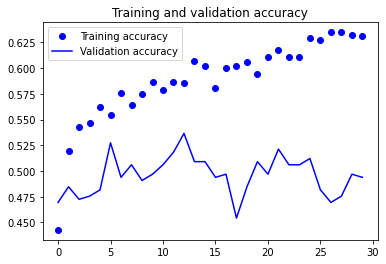

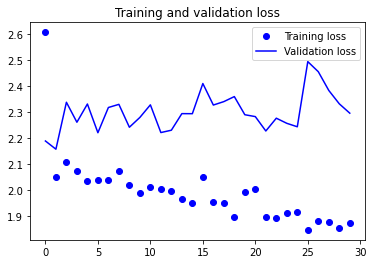

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Testing and Evaluation


In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

#### 1D CNN

In [ ]:
y_prob = x.predict(x=x1_testing, batch_size=64, verbose=1)

36/36 [==============================] - 0s 1ms/step


In [ ]:
y_pred = np.zeros(y_prob.shape[0])
for i in range(y_prob.shape[0]):
  y_pred[i]=np.argmax(y_prob[i])
y_pred = np.int32(y_pred)
y_pred

array([3, 0, 3, ..., 1, 3, 3], dtype=int32)

In [ ]:
accuracy_score(y_testing,y_pred)

0.36375545851528385

In [ ]:
f1_score(y_testing,y_pred, average='macro')

0.31840294111387446

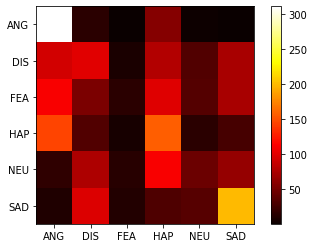

In [ ]:
a = confusion_matrix(y_testing,y_pred)
lbls =['ANG', 'DIS','FEA', 'HAP','NEU', 'SAD']

fig, ax = plt.subplots()
im = ax.imshow(a, cmap='hot', interpolation='nearest')
ax.set_xticks(range(6))
ax.set_xticklabels(lbls, rotation='horizontal')
ax.set_yticks(range(6))
ax.set_yticklabels(lbls, rotation='horizontal')

plt.colorbar(im)

plt.show()

#### 2D CNN

In [ ]:
y_prob = y.predict(x=x2_testing, batch_size=64, verbose=1)

36/36 [==============================] - 1s 17ms/step


In [ ]:
y_pred = np.zeros(y_prob.shape[0])
for i in range(y_prob.shape[0]):
  y_pred[i]=np.argmax(y_prob[i])
y_pred = np.int32(y_pred)
y_pred

array([4, 3, 1, ..., 2, 3, 3], dtype=int32)

In [ ]:
accuracy_score(y_testing,y_pred)

0.46943231441048033

In [ ]:
f1_score(y_testing,y_pred, average='macro')

0.45136286459303115

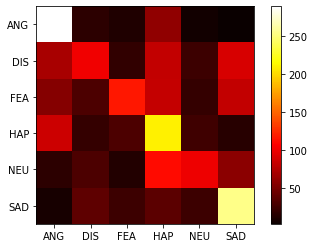

In [ ]:
a = confusion_matrix(y_testing,y_pred)
lbls =['ANG', 'DIS','FEA', 'HAP','NEU', 'SAD']

fig, ax = plt.subplots()
im = ax.imshow(a, cmap='hot', interpolation='nearest')
ax.set_xticks(range(6))
ax.set_xticklabels(lbls, rotation='horizontal')
ax.set_yticks(range(6))
ax.set_yticklabels(lbls, rotation='horizontal')

plt.colorbar(im)

plt.show()

#### Combined

In [ ]:
y_prob = model.predict(x=[x1_testing, x2_testing], batch_size=64, verbose=1)

36/36 [==============================] - 1s 18ms/step


In [ ]:
y_pred = np.zeros(y_prob.shape[0])
for i in range(y_prob.shape[0]):
  y_pred[i]=np.argmax(y_prob[i])
y_pred = np.int32(y_pred)
y_pred

array([4, 0, 1, ..., 4, 3, 4], dtype=int32)

In [ ]:
accuracy_score(y_testing,y_pred)

0.5004366812227075

In [ ]:
f1_score(y_testing,y_pred, average='macro')

0.48498373610012196

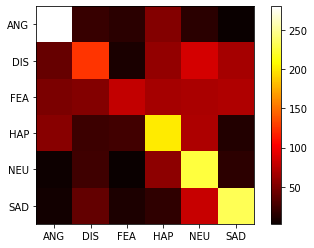

In [ ]:
a = confusion_matrix(y_testing,y_pred)
lbls =['ANG', 'DIS','FEA', 'HAP','NEU', 'SAD']

fig, ax = plt.subplots()
im = ax.imshow(a, cmap='hot', interpolation='nearest')
ax.set_xticks(range(6))
ax.set_xticklabels(lbls, rotation='horizontal')
ax.set_yticks(range(6))
ax.set_yticklabels(lbls, rotation='horizontal')

plt.colorbar(im)

plt.show()